#Preliminary operations

##Import libraries

In [ ]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# evaluation
from sklearn.metrics import silhouette_score
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

##Mount Google Drive

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import datasets

In [ ]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_low.xlsx", index_col="Unnamed: 0")

In [ ]:
df.columns

Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex', 'channels', 'length_ms', 'intensity',
       'zero_crossings_sum', 'mfcc_mean', 'mfcc_max', 'sc_mean', 'sc_std',
       'sc_min', 'sc_max', 'sc_kur', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'mean', 'kur', 'skew', 'loudness', 'emotion_type'],
      dtype='object')

In [ ]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]
# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

COSE DA FARE PER LA CLASSIFICAZIONE (PER OGNI MODELLO):

Le cose che facciamo le facciamo per tutti e 3 i dataset (all emphasis, high emphasis e low emphasis). Facciamo la classificazione per le due variabili che abbiamo usato anche nel Clustering: "emotions" e "emotional_type" (strong, weak).

* Dividere in "training_set" (80%) e "test_set" (20%)
* Usare il "training_set" per fare la Cross_Validation stratificata (Stratified Cross Validation) in 10 parti per testare gli iperparametri, con Grid-Search se non va troppo lento; se va lento usiamo Randomized-Search.
* Testare la classificazione su tutte e due le variabili dette prima, per ognuno dei 3 dataset che abbiamo
* Misuarci tutte le metriche possibili e immaginabili che ha fatto vedere lo Spinnnato in laboratorio
* Fine, basta, boh. Bona cisi e se un cisi bona

##Partitioning for emotion

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_emotion, test_size=0.2, random_state=0, stratify=y_emotion
)

##Partitioning for emotion type


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_emtype, test_size=0.2, random_state=0, stratify=y_emtype
)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
clf = KNeighborsClassifier(n_neighbors=44, metric="cityblock", weights="distance")
clf.fit(X_train, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=44, weights='distance')

In [ ]:
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)

0.29327902240325865


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint, loguniform

In [ ]:
#RANDOM SEARCH
%%time
param_grid = {
    "n_neighbors": np.arange(1, X_train.shape[0]//2),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}
grid = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=400,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

KeyboardInterrupt: ignored

In [ ]:
#GRID SEARCH (CIRCA 2 ORE)
%%time
param_grid = {
    "n_neighbors": np.arange(1, X_train.shape[0]//2), ##LEN 857
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

NameError: ignored

{'metric': 'cityblock', 'n_neighbors': 44, 'weights': 'distance'} 0.2706888602617126
CPU times: user 5min 50s, sys: 16.9 s, total: 6min 7s
Wall time: 1h 37min 20s

In [ ]:
print(grid.best_params_, grid.best_score_)

In [ ]:
#parametri attuali
clf.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cityblock',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 44,
 'p': 2,
 'weights': 'distance'}

{'weights': 'distance', 'n_neighbors': 51, 'metric': 'cityblock'} RANDOM

In [ ]:
clf.score(X_test, y_test)

0.6924643584521385

In [ ]:
grid.cv_results_

In [ ]:
results = pd.DataFrame(grid.cv_results_)
results

In [ ]:
results["metric_weight"] = results["param_metric"] + " , " + results["param_weights"]

In [ ]:
sns.lineplot(
    data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight"
)

##Evaluation metrics

In [ ]:
!pip install scikit-plot
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.28      0.38      0.32        84
        calm       0.33      0.31      0.32        72
     disgust       0.27      0.07      0.11        46
     fearful       0.31      0.31      0.31        70
       happy       0.15      0.24      0.19        63
     neutral       0.14      0.08      0.10        37
         sad       0.19      0.19      0.19        75
   surprised       0.19      0.16      0.18        44

    accuracy                           0.24       491
   macro avg       0.23      0.22      0.21       491
weighted avg       0.24      0.24      0.23       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

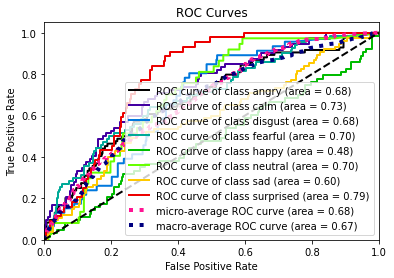

0.6706479333920637


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

#### Cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross = np.array(cross_val_score(clf, X_train, y_train, cv=10))
print(cross)
print("media", np.mean(cross))
print("deviazione std.", np.std(cross))

[0.26829268 0.24390244 0.28455285 0.25203252 0.24390244 0.19512195
 0.26229508 0.23770492 0.23770492 0.19672131]
media 0.24222311075569775
deviazione std. 0.027029500492542668


In [ ]:
# Dummy clf
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.13441955193482688


# High emphasis

##Emotion

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# replacing training_set 
# (removing common samples between training_set and test_set)
X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emotion_emph_high[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test_eh = std_sclr.transform(X_test)

##Emotion type


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split train- and test- set
X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emtype_emph_high[X_train_index]

In [ ]:
clf = KNeighborsClassifier(n_neighbors=44, metric="cityblock", weights="distance")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test_eh)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.48      0.55        75
        calm       0.39      0.61      0.48        75
     disgust       0.31      0.21      0.25        39
     fearful       0.44      0.37      0.40        75
       happy       0.33      0.36      0.35        75
     neutral       0.27      0.21      0.24        38
         sad       0.29      0.21      0.24        75
   surprised       0.34      0.54      0.42        39

    accuracy                           0.39       491
   macro avg       0.38      0.37      0.37       491
weighted avg       0.39      0.39      0.38       491



In [ ]:
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_train, y_train))
print(dummy_clf.score(X_test, y_test))

0.1274787535410765
0.13034623217922606


In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

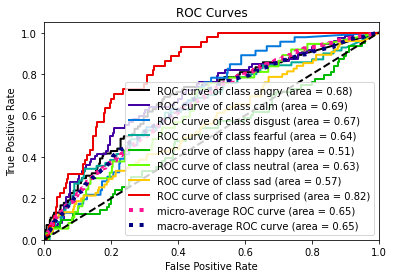

0.6509132635203957


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test), figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("clf_roc_curve.svg", format="svg")
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

In [ ]:

plot_precision_recall(y_test, DT.predict_proba(X_test), figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("DT_precision_recall.svg", format="svg")
plt.show()

# Low emphasis


##Emotion

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# replacing training_set 
# (removing common samples between training_set and test_set)
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emotion_emph_low[X_train_index]

##Emotion type


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split train- and test- set
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emtype_emph_low[X_train_index]

In [ ]:
clf = KNeighborsClassifier(n_neighbors=44, metric="cityblock", weights="distance")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.0

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        84
        calm       1.00      1.00      1.00        72
     disgust       1.00      1.00      1.00        46
     fearful       1.00      1.00      1.00        70
       happy       1.00      1.00      1.00        63
     neutral       1.00      1.00      1.00        37
         sad       1.00      1.00      1.00        75
   surprised       1.00      1.00      1.00        44

    accuracy                           1.00       491
   macro avg       1.00      1.00      1.00       491
weighted avg       1.00      1.00      1.00       491



In [ ]:
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_train, y_train))
print(dummy_clf.score(X_test, y_test))

0.5532150776053215
0.0


In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

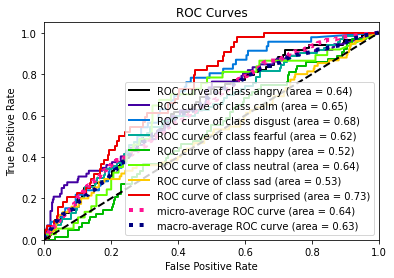

0.6263152856925572


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

##All emphasis (50% samples)

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    train_size=0.5,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.13441955193482688


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.27      0.52      0.36        75
        calm       0.24      0.19      0.21        75
     disgust       0.09      0.03      0.04        39
     fearful       0.30      0.31      0.30        75
       happy       0.20      0.20      0.20        75
     neutral       0.14      0.03      0.04        38
         sad       0.18      0.21      0.20        75
   surprised       0.26      0.23      0.25        39

    accuracy                           0.24       491
   macro avg       0.21      0.21      0.20       491
weighted avg       0.22      0.24      0.22       491



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)

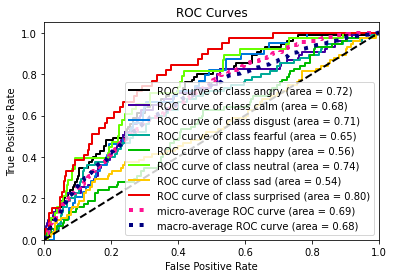

0.674401389783934


In [ ]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

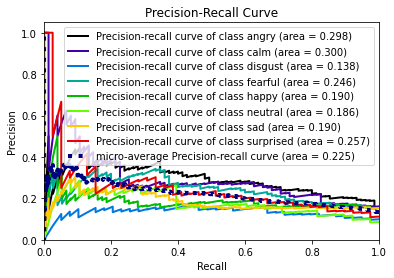

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()